In [3]:
# Import libraries
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shutil
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [4]:
from __future__ import print_function
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.layers import Dropout

In [5]:
# Settings
print("TensorFlow version:", tf.__version__)

original_train_dir = r'C:/Users/VICTUS/OneDrive/Desktop/Odia/dataset/train'
test_dir = r'C:/Users/VICTUS/OneDrive/Desktop/Odia/dataset/test'

augmented_dir = 'augmented_train_data'
final_train_dir = 'final_dataset/train'
final_val_dir = 'final_dataset/val'

image_size = (64, 64)
batch_size = 64 
epochs = 10      
target_count = 300

TensorFlow version: 2.19.0


In [13]:
# Data Augmentation
os.makedirs(augmented_dir, exist_ok=True)

augmentor = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1
)

for class_folder in os.listdir(original_train_dir):
    class_path = os.path.join(original_train_dir, class_folder)
    aug_class_path = os.path.join(augmented_dir, class_folder)
    os.makedirs(aug_class_path, exist_ok=True)

    images = os.listdir(class_path)
    for img_name in images:
        shutil.copy(os.path.join(class_path, img_name), os.path.join(aug_class_path, img_name))

    if len(images) < target_count:
        needed = target_count - len(images)
        while needed > 0:
            img_name = random.choice(images)
            img_path = os.path.join(class_path, img_name)

            img = load_img(img_path)
            img_array = img_to_array(img)
            img_array = img_array.reshape((1,) + img_array.shape)

            for batch in augmentor.flow(img_array, batch_size=1, save_to_dir=aug_class_path, save_prefix='aug', save_format='png'):
                needed -= 1
                if needed <= 0:
                    break

print("Data augmentation completed!")

Data augmentation completed!


In [14]:
#Train-Validation Split
# --------------------------------------------
os.makedirs(final_train_dir, exist_ok=True)
os.makedirs(final_val_dir, exist_ok=True)

for class_folder in os.listdir(augmented_dir):
    class_path = os.path.join(augmented_dir, class_folder)
    images = os.listdir(class_path)
    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    train_class_dir = os.path.join(final_train_dir, class_folder)
    val_class_dir = os.path.join(final_val_dir, class_folder)
    os.makedirs(train_class_dir, exist_ok=True)
    os.makedirs(val_class_dir, exist_ok=True)

    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_class_dir, img))
    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_class_dir, img))

print(" Data split completed!")

 Data split completed!


In [6]:
#Prepare Datasets
class_names = sorted(os.listdir(final_train_dir))
num_classes = len(class_names)

train_labels = []
for idx, folder in enumerate(class_names):
    folder_path = os.path.join(final_train_dir, folder)
    train_labels.extend([idx] * len(os.listdir(folder_path)))

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = dict(enumerate(class_weights))

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    final_train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    final_val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 52289 images belonging to 45 classes.
Found 20277 images belonging to 45 classes.
Found 1800 images belonging to 45 classes.


In [9]:
input_shape = (64, 64, 3)
model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64,(5,5),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(45, activation='softmax'))

E:\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)               │ (None, 60, 60, 32)    │        2,432 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 59, 59, 32)    │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_1 (Conv2D)             │ (None, 55, 55, 32)    │       25,632 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_1               │ (None, 27, 27, 32)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ conv2d_2 (Conv2D)             │ (None, 23, 23, 64)    │       51,264 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ max_pooling2d_2               │ (None, 11, 11, 64)    │            0 │
│ (MaxPooling2D)                │                       │              │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout (Dropout)             │ (None, 11, 11, 64)    │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ flatten (Flatten)             │ (None, 7744)          │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense (Dense)                 │ (None, 128)           │      991,360 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_1 (Dense)               │ (None, 256)           │       33,024 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dropout_1 (Dropout)           │ (None, 256)           │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ dense_2 (Dense)               │ (None, 45)            │       11,565 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 1,115,277 (4.25 MB)

 Trainable params: 1,115,277 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

In [94]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [96]:
history = model.fit(
    train_generator,
    steps_per_epoch=200,
    epochs=epochs,
    validation_data=validation_generator,
    class_weight=class_weights,
   # callbacks=callbacks
)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 57s 271ms/step - accuracy: 0.0684 - loss: 3.6323 - val_accuracy: 0.4547 - val_loss: 2.0674
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 53s 265ms/step - accuracy: 0.4609 - loss: 1.9708 - val_accuracy: 0.8403 - val_loss: 0.6623
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 52s 262ms/step - accuracy: 0.7603 - loss: 0.8612 - val_accuracy: 0.9310 - val_loss: 0.3131
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 52s 258ms/step - accuracy: 0.8705 - loss: 0.4834 - val_accuracy: 0.9517 - val_loss: 0.2069
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - accuracy: 0.9136 - loss: 0.3221 - val_accuracy: 0.9540 - val_loss: 0.1928
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 52s 260ms/step - accuracy: 0.9160 - loss: 0.3059 - val_accuracy: 0.9661 - val_loss: 0.1335
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 51s 257ms/step - accuracy: 0.9303 - loss: 0.2432 - val_accuracy: 0.9732 - val_loss: 0.1043
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 52s 261ms/step - accuracy: 0.9435 - loss: 0

In [ ]:
model.load_weights('best_model.keras')

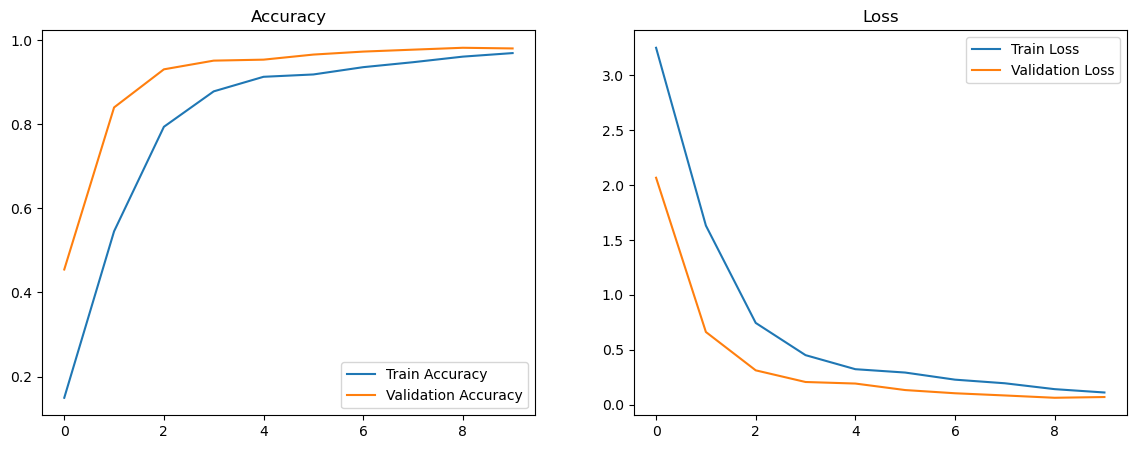

In [100]:
#Evaluate Model
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()

In [112]:
pred_probs = model.predict(test_generator)
pred_classes = np.argmax(pred_probs, axis=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step


In [116]:
true_classes = test_generator.classes

# Manual accuracy calculation
accuracy = np.sum(pred_classes == true_classes) / len(true_classes)

print(f"Manual validation accuracy: {accuracy * 100:.2f}%")

Manual validation accuracy: 79.44%


In [104]:
print(classification_report(test_generator.classes, pred_classes, target_names=list(test_generator.class_indices.keys())))

              precision    recall  f1-score   support

           ଅ       0.95      0.50      0.66        40
           ଆ       0.49      1.00      0.66        40
           ଇ       0.65      1.00      0.78        40
           ଈ       0.73      0.93      0.81        40
           ଉ       0.61      0.95      0.75        40
           ଊ       1.00      0.68      0.81        40
           ଋ       0.57      0.57      0.57        40
           ଏ       0.97      0.85      0.91        40
           ଐ       0.82      0.90      0.86        40
           ଓ       0.91      0.72      0.81        40
           ଔ       0.97      0.85      0.91        40
           କ       0.73      0.88      0.80        40
           ଖ       0.75      0.53      0.62        40
           ଗ       0.88      0.70      0.78        40
           ଘ       0.79      0.82      0.80        40
           ଙ       0.85      0.88      0.86        40
           ଚ       0.78      0.97      0.87        40
           ଛ       0.90    